## Import necessary modules
Run this cell before running any other cells

In [ ]:
from uuid import uuid4
uuid4()

In [1]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


LOG.propagate = False

# Printing and Logging
## Printing
You can use the **print()** function in Python to print messages to the screen. <br>
The message can be a string, or any other object, the object will be converted into a string before it is written to the screen. <br>

## Logging
You could use the logging module that is setup in *utils.py*. <br>
It prints to both your screen (standard output) as well as to log files (*ble.log*) in the *logs* directory. <br>
This is the recommended way to output messages, since the log files can help with debugging. <br>
The logging module also provides different log levels as shown below, each formatted with a different color for increased visibility. <br>

__**NOTE**__: You may notice that the DEBUG message is not printed to the screen but is printed in the log file. This is because the logging level for the screen is set to INFO and for the file is set to DEBUG. You can change the default log levels in *utils.py* (**STREAM_LOG_LEVEL** and **FILE_LOG_LEVEL**). 

## Formatting output
To format your strings, you may use %-formatting, str.format() or f-strings. <br>
The most "pythonic" way would be to use f-strings. [Here](https://realpython.com/python-f-strings/) is a good tutorial on f-strings. <br>

In [ ]:
LOG.debug("debug")
LOG.info("info")
LOG.warning("warning")
LOG.error("error")
LOG.critical("critical")

<hr>

# BLE
## ArtemisBLEController
The class **ArtemisBLEController** (defined in *ble.py*) provides member functions to handle various BLE operations to send and receive data to/from the Artemis board, provided the accompanying Arduino sketch is running on the Artemis board. <br>

<table align="left">
     <tr>
        <th style="text-align: left; font-size: medium">Member Functions</th>
        <th style="text-align: left; font-size: medium">Description</th style="text-align: left">
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">reload_config()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Reload changes made in <em>connection.yaml.</em></span></th style="text-align: left">
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">connect()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Connect to the Artemis board, whose MAC address is specified in <em>connection.yaml</em>.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">disconnect()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Disconnect from the Artemis board.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">is_connected()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Return a boolean indicating whether your controller is connected to the Artemis board or not.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">send_command(cmd_type, data)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Send the command <strong>cmd_type</strong> (integer) with <strong>data</strong> (string) to the Artemis board.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">receive_float(uuid) <br> receive_string(uuid) <br> receive_int(uuid)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Read the GATT characteristic (specified by its <strong>uuid</strong>) of type float, string or int. <br> The type of the GATT
            characteristic is determined by the classes BLEFloatCharacteristic, BLECStringCharacteristic or
            BLEIntCharacteristic in the Arduino sketch.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">start_notify(uuid, notification_handler)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Activate notifications on the GATT characteristic (specified by its <strong>uuid</strong>). <br> <strong>notification_handler</strong> is a
            function callback which must accept two inputs; the first will be a uuid string object and the second will
            be the bytearray of the characteristic value.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">bytearray_to_float(byte_array) <br> bytearray_to_string(byte_array) <br> bytearray_to_int(byte_array)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Convert the <strong>bytearray</strong> to float, string or int, respectively. <br> You may use these functions inside your
            notification callback function.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">stop_notify(uuid)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Stop notifications on the GATT characteristic (specified by its <strong>uuid</strong>).</span></th>
    </tr>
</table>

<table align="left">
     <tr>
        <th style="text-align: left; font-size: medium">Member Variables</th>
        <th style="text-align: left; font-size: medium">Description</th style="text-align: left">
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">uuid</span></th>
        <th style="text-align: left"><span style="font-weight: normal">A dictionary that stores the UUIDs of the various characteristics specified in <em>connection.yaml</em>.</span></th>
    </tr>
</table>

## Configuration
- The MAC address, Service UUID and GATT characteristic UUIDs are defined in the file: *connection.yaml*.
- They should match the UUIDs used in the Arduino sketch.
- The artemis board running the base code should display its MAC address in the serial monitor.
- Update the **artemis_address** in *connection.yaml*, accordingly.
- Make sure to call **ble.reload_config()** or **get_ble_controller()** (which internally calls **reload_config()**) after making any changes to your configuration file.

<hr>

In the below cell, we create an **ArtemisBLEController** object using **get_ble_controller()** (defined in *ble.py*), which creates and/or returns a single instance of **ArtemisBLEController**. <br>
<span style="color:rgb(240,50,50)"> __NOTE__: Do not use the class directly to instantiate an object. </span><br>

In [ ]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

## Receive data from the Artemis board

The cell below shows examples of reading different types (as defined in the Arduino sketch) of GATT characteristics.

In [ ]:
# Read a float GATT Charactersistic
f = ble.receive_float(ble.uuid['RX_FLOAT'])
print(f)

In [ ]:
# Read a string GATT Charactersistic
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)

## Send a command to the Artemis board
Send the PING command and read the reply string from the string characteristic RX_STRING. <br>
__NOTE__: The **send_command()** essentially sends a string data to the GATT characteristic (TX_CMD_STRING). The GATT characteristic in the Arduino sketch is of type BLECStringCharacteristic.

In [ ]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

Lab2 Task1: ECHO Command

In [ ]:
ble.send_command(CMD.ECHO, "hi")
echo_rx = ble.receive_string(ble.uuid['RX_STRING'])
print(echo_rx)

Lab3 task6

In [ ]:
# Get ArtemisBLEController object
ble = get_ble_controller()
# Connect to the Artemis Device
ble.connect()

In [ ]:
ble.stop_notify(ble.uuid["RX_STRING"])

In [ ]:
time_stamps = []
dist1_stamps = []
dist2_stamps = []

In [ ]:
def time_dist_notification_handler(uuid, char_bytearr):
    global time_stamps, dist1_stamps, dist2_stamps
    string = ble.bytearray_to_string(char_bytearr)
    # parts = string.split("\t")  
    parts = string.split("|")  
    print(parts)
    time_stamps.append(parts[0])
    dist1_stamps.append(parts[1])
    dist2_stamps.append(parts[2])

In [ ]:
ble.start_notify(ble.uuid["RX_STRING"], time_dist_notification_handler)

In [ ]:
ble.send_command(CMD.TOF_READINGS, "")

In [ ]:
print(len(time_stamps))
print(len(dist1_stamps))
print(len(dist2_stamps))

In [ ]:
time_arr, dist1_arr, dist2_arr = [], [], []
for i in range(len(time_stamps)):
    time_arr.append(int(time_stamps[i][2:]))
    dist1_arr.append(int(dist1_stamps[i][6:]))
    dist2_arr.append(int(dist2_stamps[i][6:]))

In [ ]:
print(time_arr)
print(dist1_arr)
print(dist2_arr)

In [ ]:
plt.plot(time_arr, dist1_arr, "red", label="dist1")
plt.plot(time_arr, dist2_arr, "blue", label="dist2")
plt.xlabel("time(ms)")
plt.ylabel("distance(mm)")
plt.legend()
plt.show()

In [ ]:
ble.stop_notify(ble.uuid["RX_STRING"])

Lab2 Task4

In [ ]:
# Get ArtemisBLEController object
ble = get_ble_controller()
# Connect to the Artemis Device
ble.connect()

In [ ]:
time_stamps = []
acc_x = []
acc_y = []
acc_z = []
gyr_x = []
gyr_y = []
gyr_z = []


In [ ]:
def lab2_notification_handler(uuid, char_bytearr):
    global time_stamps, acc_x, acc_y, acc_z, gyr_x, gyr_y, gyr_z
    string = ble.bytearray_to_string(char_bytearr)
    parts = string.split("|")  
    print(parts)
    time_stamps.append(parts[0][2:])
    acc_x.append(parts[1][6:])
    acc_y.append(parts[2][6:])
    acc_z.append(parts[3][6:])
    gyr_x.append(parts[4][6:])
    gyr_y.append(parts[5][6:])
    gyr_z.append(parts[6][6:])

In [ ]:
ble.start_notify(ble.uuid["RX_STRING"], lab2_notification_handler)

In [ ]:
ble.send_command(CMD.LAB2_SAMPLE_DATA, "")

In [ ]:
print(time_stamps)

In [ ]:
time_arr, acc_x_arr, acc_y_arr, acc_z_arr, gyr_x_arr, gyr_y_arr, gyr_z_arr = [], [], [], [], [], [], []
for i in range(len(time_stamps)):
    time_arr.append(int(time_stamps[i]))
    acc_x_arr.append(float(acc_x[i]))
    acc_y_arr.append(float(acc_y[i]))
    acc_z_arr.append(float(acc_z[i]))
    gyr_x_arr.append(float(gyr_x[i]))
    gyr_y_arr.append(float(gyr_y[i]))
    gyr_z_arr.append(float(gyr_z[i]))

In [ ]:
# speed of sampling
duration = (time_arr[-1] - time_arr[1]) / 1000
trans_num = len(time_arr) - 1
speed = trans_num / duration
print("Speed of sampling is :", speed, "Hz")

Lab4

In [ ]:
# Get ArtemisBLEController object
ble = get_ble_controller()
# Connect to the Artemis Device
ble.connect()

In [ ]:
ble.send_command(CMD.GO_FORWARD, "")

In [ ]:
ble.send_command(CMD.SELF_ROTATE, "")

In [ ]:
ble.send_command(CMD.OPEN_LOOP_CONTROL, "")

Lab5

In [ ]:
# Get ArtemisBLEController object
ble = get_ble_controller()
# Connect to the Artemis Device
ble.connect()

In [ ]:
timeData = []
tof1Data = []
tof2Data = []
leftPWM = []
rightPWM = []
errorData = []
p_data = []
i_data = []
d_data = []

In [ ]:
def pid_fd_notification_handler(uuid, char_bytearr):
    global timeData, tof1Data, tof2Data, leftPWM, rightPWM, errorData, p_data, i_data, d_data
    string = ble.bytearray_to_string(char_bytearr)
    parts = string.split("|")  
    print(parts)
    timeData.append(int(parts[0][2:]))
    tof1Data.append(float(parts[1][6:]))
    tof2Data.append(float(parts[2][6:]))
    leftPWM.append(float(parts[3][8:]))
    rightPWM.append(float(parts[4][9:]))
    errorData.append(float(parts[5][10:]))
    p_data.append(float(parts[6][7:]))
    i_data.append(float(parts[7][7:]))
    d_data.append(float(parts[8][7:]))
    

In [ ]:
ble.start_notify(ble.uuid["RX_STRING"], pid_fd_notification_handler)

In [ ]:
# ble.send_command(CMD.TOF_READINGS, "")

In [ ]:
ble.send_command(CMD.PID_STATUS_INI, "1")

In [ ]:
ble.send_command(CMD.PID_FD, "")

In [ ]:
ble.send_command(CMD.SEND_PID_FD_DEBUG_READINGS, "")

In [ ]:
reading_count = 5
duration = 29 * 0.001
pid_general_reading_freq = reading_count / duration
print("The pid_general_reading_freq = ", pid_general_reading_freq, "Hz")
#The pid_general_reading_freq =  172.41379310344826 Hz

tof_same_reading_count = 15 # update once every 15 samples
tof_duration = (247-148)*0.001
tof_reading_freq = 1 / tof_duration
print("The tof reading update rate = ", tof_reading_freq, "Hz")
#The tof reading update rate =  10.1010101010101 Hz

In [ ]:
print(len(timeData))
print(len(tof1Data))
print(len(leftPWM))
print(len(p_data))
print(len(i_data))
# print(np.array(timeData))
# print(np.array(tof1Data))
# # print(np.array(leftPWM))
# print(np.array(p_data))
# print(np.array(i_data))


In [ ]:
unused_index_arr = np.argwhere(np.array(timeData)==0)
if (len(unused_index_arr) != 0):
    unused_index = unused_index_arr[0][0]
else:
    unused_index = len(timeData)
print(unused_index)

In [ ]:
# plot front distance vs time
plt.figure(figsize=(15, 10))
# plt.scatter(np.array(timeData), np.array(tof1Data), color="blue", label="distance")
# dispose unused array parts

plt.plot(np.array(timeData)[:unused_index], np.array(tof1Data)[:unused_index], linestyle='-', marker='o', color='blue', label='distance')
plt.title("distance vs time")
plt.xlabel("time(ms)")
plt.ylabel("distance(mm)")
plt.show()

In [ ]:
# plot front error vs time
plt.figure(figsize=(15, 10))
# plt.scatter(np.array(timeData), np.array(tof1Data), color="blue", label="distance")
plt.plot(np.array(timeData)[:unused_index], np.array(errorData)[:unused_index], linestyle='-', marker='o', color='green', label='error')
plt.plot(np.array(timeData)[:unused_index], np.zeros((len(timeData)))[:unused_index], linestyle='--', color='black', label='error')
plt.title("error vs time")
plt.xlabel("time(ms)")
plt.ylabel("error(mm)")
plt.show()

In [ ]:
# plot PWM value vs time
# plt.figure(figsize=(15, 10))
plt.plot(np.array(timeData)[:unused_index], np.array(leftPWM)[:unused_index], linestyle='-', marker='o', color='red', label='PWM')
plt.title("PWM value vs time")
plt.xlabel("time(ms)")
plt.ylabel("PWM value")
plt.show()

In [ ]:
# # plot P I  value vs time
# plt.figure(figsize=(15, 8))
# plt.plot(np.array(timeData)[:unused_index], np.array(p_data)[:unused_index], linestyle='-', marker='o', color='red', label='p_data')
# plt.plot(np.array(timeData)[:unused_index], np.array(i_data)[:unused_index], linestyle='-', marker='o', color='blue', label='i_data')
# plt.plot(np.array(timeData)[:unused_index], np.array(d_data)[:unused_index], linestyle='-', marker='o', color='green', label='d_data')
# plt.title("P&I&D value vs time")
# plt.legend()
# plt.xlabel("time(ms)")
# plt.ylabel("P & I & D value")
# plt.show()

In [ ]:
# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8), sharex=True)

# Plot P data
ax1.plot(np.array(timeData)[:unused_index], np.array(p_data)[:unused_index], linestyle='-', marker='o', color='red', label='p_data')
ax1.set_ylabel('P value')

# Plot I data
ax2.plot(np.array(timeData)[:unused_index], np.array(i_data)[:unused_index], linestyle='-', marker='o', color='blue', label='i_data')
ax2.set_ylabel('I value')

# Plot D data
ax3.plot(np.array(timeData)[:unused_index], np.array(d_data)[:unused_index], linestyle='-', marker='o', color='green', label='d_data')
ax3.set_ylabel('D value')
ax3.set_xlabel('time (ms)')

# Set title and legend
plt.suptitle('P&I&D value vs time')
# plt.legend()

# Display the figure
plt.show()

Lab6

In [ ]:
# Get ArtemisBLEController object
ble = get_ble_controller()
# Connect to the Artemis Device
ble.connect()

In [ ]:
# ble.send_command(CMD.GYR_READINGS, "")

In [ ]:
timeData = []
yawData = []
leftPWM = []
rightPWM = []
yawErrorData = []
p_data = []
i_data = []
d_data = []
powerData = []

In [ ]:
def pid_orient_notification_handler(uuid, char_bytearr):
    global timeData, yawData, leftPWM, rightPWM, yawErrorData, p_data, i_data, d_data, powerData
    string = ble.bytearray_to_string(char_bytearr)
    parts = string.split("|")  
    print(parts)
    timeData.append(int(parts[0][2:]))
    yawData.append(float(parts[1][4:]))
    leftPWM.append(float(parts[2][8:]))
    rightPWM.append(float(parts[3][9:]))
    yawErrorData.append(float(parts[4][9:]))
    p_data.append(float(parts[5][7:]))
    i_data.append(float(parts[6][7:]))
    d_data.append(float(parts[7][7:]))
    powerData.append(float(parts[8][10:]))
    

In [ ]:
ble.start_notify(ble.uuid["RX_STRING"], pid_orient_notification_handler)

In [ ]:
ble.send_command(CMD.PID_STATUS_INI, "1")

In [ ]:
ble.send_command(CMD.PID_ORIENT, "")

In [ ]:
ble.send_command(CMD.SEND_PID_ORIENT_DEBUG_READINGS, "")

In [ ]:
print(len(timeData))
print(len(yawData))
print(len(leftPWM))
print(len(p_data))
print(len(i_data))
print(len(powerData))

In [ ]:
unused_index_arr = np.argwhere(np.array(timeData)==0)
if (len(unused_index_arr) != 0):
    unused_index = unused_index_arr[0][0]
else:
    unused_index = len(timeData)
print(unused_index)

In [ ]:
# plot Yaw vs time
# plt.figure(figsize=(15, 10))
plt.plot(np.array(timeData)[:unused_index], np.array(yawData)[:unused_index], linestyle='-', marker='o', color='blue', label='yaw')
# plt.plot(np.array(timeData), np.array(yawData), linestyle='-', marker='o', color='blue', label='yaw')
plt.title("yaw vs time")
plt.xlabel("time(ms)")
plt.ylabel("yaw(degree)")
plt.show()

In [ ]:
# plot yaw error vs time
# plt.figure(figsize=(15, 10))
plt.plot(np.array(timeData)[:unused_index], np.array(yawErrorData)[:unused_index], linestyle='-', marker='o', color='green', label='yaw error')
plt.plot(np.array(timeData)[:unused_index], np.zeros((len(timeData)))[:unused_index], linestyle='--', color='black')
# plt.plot(np.array(timeData), np.array(yawErrorData), linestyle='-', marker='o', color='green', label='yaw error')
# plt.plot(np.array(timeData), np.zeros((len(timeData))), linestyle='--', color='black')
plt.title("yaw error vs time")
plt.xlabel("time(ms)")
plt.ylabel("yaw error(degree)")
plt.show()

In [ ]:
# plot real power vs time
# plt.figure(figsize=(15, 10))
plt.plot(np.array(timeData)[:unused_index], np.array(powerData)[:unused_index], linestyle='-', marker='o', color='green', label='yaw error')
plt.title("real_power vs time")
plt.xlabel("time(ms)")
plt.ylabel("real_power")
plt.show()

In [ ]:
# plot PWM left value vs time
plt.figure(figsize=(15, 10))
plt.plot(np.array(timeData)[:unused_index], np.array(leftPWM)[:unused_index], linestyle='-', marker='o', color='red', label='PWM')
# plt.plot(np.array(timeData), np.array(leftPWM), linestyle='-', marker='o', color='red', label='PWM')
plt.title("left PWM value vs time")
plt.xlabel("time(ms)")
plt.ylabel("PWM value")
plt.show()

In [ ]:
# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8), sharex=True)

# Plot P data
ax1.plot(np.array(timeData)[:unused_index], np.array(p_data)[:unused_index], linestyle='-', marker='o', color='red', label='p_data')
# ax1.plot(np.array(timeData), np.array(p_data), linestyle='-', marker='o', color='red', label='p_data')
ax1.set_ylabel('P value')
ax3.set_xlabel('time (ms)')

# Plot I data
ax2.plot(np.array(timeData)[:unused_index], np.array(i_data)[:unused_index], linestyle='-', marker='o', color='blue', label='i_data')
# ax2.plot(np.array(timeData), np.array(i_data), linestyle='-', marker='o', color='blue', label='i_data')
ax2.set_ylabel('I value')
ax3.set_xlabel('time (ms)')

# Plot D data
ax3.plot(np.array(timeData)[:unused_index], np.array(d_data)[:unused_index], linestyle='-', marker='o', color='green', label='d_data')
# ax3.plot(np.array(timeData), np.array(d_data), linestyle='-', marker='o', color='green', label='d_data')
ax3.set_ylabel('D value')
ax3.set_xlabel('time (ms)')

# Set title and legend
plt.suptitle('P&I&D value vs time')
# plt.legend()

# Display the figure
plt.show()

Lab7 - Kalman Filter

In [36]:
# Get ArtemisBLEController object
ble = get_ble_controller()
# Connect to the Artemis Device
ble.connect()

2024-03-20 12:06:45,618 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:42:30:78:92:49


2024-03-20 12:06:48,260 | INFO     |: Connected to c0:42:30:78:92:49


/Users/harrypeng/Desktop/ECE4160/lab1/ble_robot-1.1/ble_python/base_ble.py:104: FutureWarning: This method will be removed future version, pass the callback to the BleakClient constructor instead.
  self.client.set_disconnected_callback(self.disconnect_handler)


In [37]:
timeData = []
tof1Data = []
tof2Data = []
leftPWM = []
rightPWM = []
errorData = []
p_data = []
i_data = []
d_data = []

In [38]:
def pid_fd_notification_handler(uuid, char_bytearr):
    global timeData, tof1Data, tof2Data, leftPWM, rightPWM, errorData, p_data, i_data, d_data
    string = ble.bytearray_to_string(char_bytearr)
    parts = string.split("|")  
    print(parts)
    timeData.append(int(parts[0][2:]))
    tof1Data.append(float(parts[1][6:]))
    tof2Data.append(float(parts[2][6:]))
    leftPWM.append(float(parts[3][8:]))
    rightPWM.append(float(parts[4][9:]))
    errorData.append(float(parts[5][10:]))
    p_data.append(float(parts[6][7:]))
    i_data.append(float(parts[7][7:]))
    d_data.append(float(parts[8][7:]))
    

In [39]:
ble.start_notify(ble.uuid["RX_STRING"], pid_fd_notification_handler)

In [40]:
ble.send_command(CMD.PID_STATUS_INI, "1")

In [41]:
ble.send_command(CMD.KALMAN_FILTER_TEST, "")

In [ ]:
ble.send_command(CMD.SEND_PID_FD_DEBUG_READINGS, "")

['T:2', 'Dist1:3740.0', 'Dist2:0.0', 'leftPWM:0.0', 'rightPWM:0.0', 'errorData:0.0', 'pData:0.0', 'iData:0.0', 'dData:0.0']


['T:10', 'Dist1:3740.0', 'Dist2:0.0', 'leftPWM:0.0', 'rightPWM:0.0', 'errorData:0.0', 'pData:0.0', 'iData:0.0', 'dData:0.0']
['T:18', 'Dist1:3740.0', 'Dist2:0.0', 'leftPWM:0.0', 'rightPWM:0.0', 'errorData:0.0', 'pData:0.0', 'iData:0.0', 'dData:0.0']
['T:23', 'Dist1:3740.0', 'Dist2:0.0', 'leftPWM:0.0', 'rightPWM:0.0', 'errorData:0.0', 'pData:0.0', 'iData:0.0', 'dData:0.0']
['T:31', 'Dist1:3740.0', 'Dist2:0.0', 'leftPWM:0.0', 'rightPWM:0.0', 'errorData:0.0', 'pData:0.0', 'iData:0.0', 'dData:0.0']
['T:35', 'Dist1:3740.0', 'Dist2:0.0', 'leftPWM:0.0', 'rightPWM:0.0', 'errorData:0.0', 'pData:0.0', 'iData:0.0', 'dData:0.0']
['T:43', 'Dist1:3740.0', 'Dist2:0.0', 'leftPWM:0.0', 'rightPWM:0.0', 'errorData:0.0', 'pData:0.0', 'iData:0.0', 'dData:0.0']
['T:49', 'Dist1:3740.0', 'Dist2:0.0', 'leftPWM:0.0', 'rightPWM:0.0', 'errorData:0.0', 'pData:0.0', 'iData:0.0', 'dData:0.0']
['T:57', 'Dist1:3740.0', 'Dist2:0.0', 'leftPWM:0.0', 'rightPWM:0.0', 'errorData:0.0', 'pData:0.0', 'iData:0.0', 'dData:0.0']


In [86]:
# Define the filename (use the actual path to your CSV file)
filename = "/Users/harrypeng/Desktop/ECE4160/lab1/ble_robot-1.1/ble_python/kalman_readings_csv/time_dist_2024-03-20_12-16-20.csv"

# Load the data from the CSV file
loaded_data = np.loadtxt(filename, delimiter=',', skiprows=1)  # skip the header row

# Split the loaded data into two arrays
timeData = np.array(loaded_data[:, 0])  # unit: s
tof1Data = np.array(loaded_data[:, 1])/1000  # unit: m


In [43]:
# # # change unit
# timeData = np.array(timeData) / 1000    # unit: s
# tof1Data = np.array(tof1Data) / 1000    # unit: m

# # timeData = np.array(timeData)   
# # tof1Data = np.array(tof1Data)   

In [87]:
print(len(timeData))
print(len(tof1Data))
print(len(leftPWM))
print(len(p_data))
print(len(i_data))

1000
1000
1000
1000
1000


In [88]:
unused_index_arr = np.argwhere(np.array(timeData)==0)
if (len(unused_index_arr) != 0):
    unused_index = unused_index_arr[0][0]
else:
    unused_index = len(timeData)
print(unused_index)

334


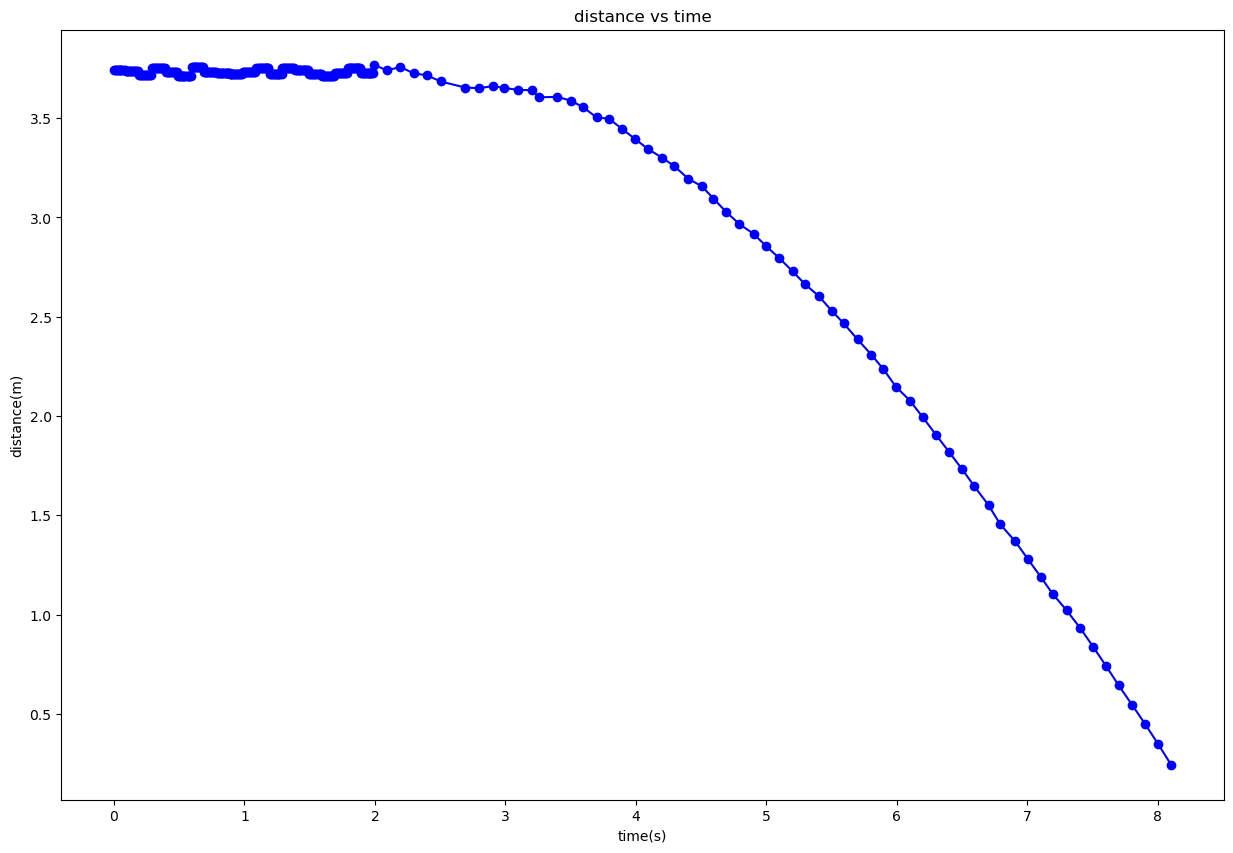

In [90]:
# plot distance vs time
plt.figure(figsize=(15, 10))
plt.plot(timeData[:unused_index], tof1Data[:unused_index], linestyle='-', marker='o', color='blue', label='distance')
plt.title("distance vs time")
plt.xlabel("time(s)")
plt.ylabel("distance(m)")
plt.show()


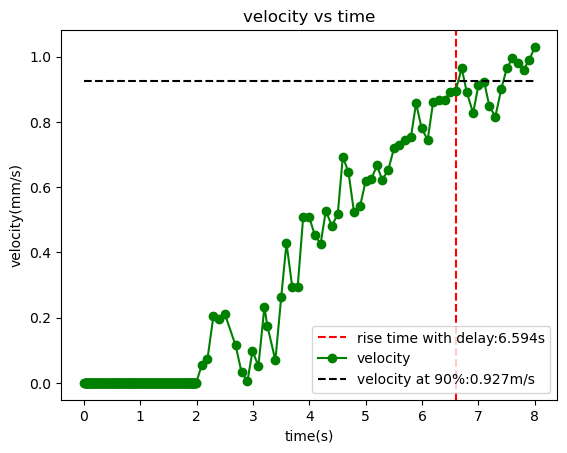

In [92]:
# plot velocity vs time
##### use three points to calculate the middle point's velocity
start_index = np.argwhere(np.array(timeData)>2)[0][0]
velocityData = []
for i in range(1, (unused_index-1)):
    if (i < start_index):
        velocityData.append(0)
    else:
        velocityData.append(np.abs((tof1Data[i-1]-tof1Data[i+1])/(timeData[i+1] - timeData[i-1])))

velocityData = np.array(velocityData)
final_velocity = np.max(velocityData)
steady_state_velocity = round(0.9*final_velocity, 3)

rise_time_with_delay = timeData[np.argwhere(velocityData>=0.9*final_velocity)[0][0]]
rise_time = rise_time_with_delay - 2 # deduct the first 2 sec delay

plt.axvline(x=rise_time_with_delay, color='red', linestyle='--', label=f"rise time with delay:{rise_time_with_delay}s")
plt.plot(timeData[1:unused_index-1], velocityData, linestyle='-', marker='o', color='green', label='velocity')
plt.plot(timeData[:unused_index-1], np.ones(np.shape(timeData[:unused_index-1]))*steady_state_velocity, linestyle='--', color='black', label=f'velocity at 90%:{steady_state_velocity}m/s')
plt.title("velocity vs time")
plt.xlabel("time(s)")
plt.ylabel("velocity(mm/s)")
plt.legend()
plt.show()

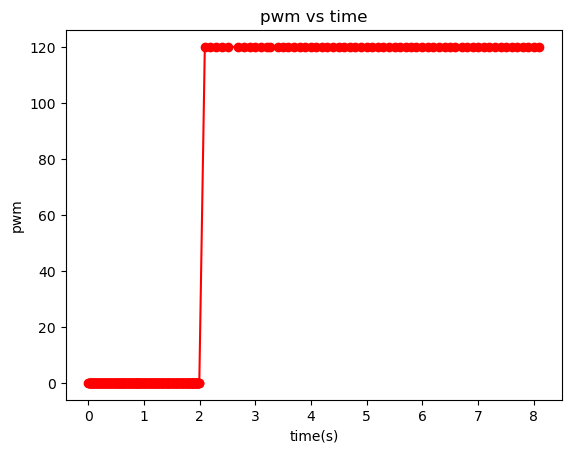

In [93]:
# plot pwm vs time
plt.plot(timeData[:unused_index], leftPWM[:unused_index], linestyle='-', marker='o', color='red', label='pwm')
plt.title("pwm vs time")
plt.xlabel("time(s)")
plt.ylabel("pwm")
plt.show()

In [58]:
# # save the readings data
# # Stack the arrays vertically
# data = np.vstack((timeData, tof1Data))

# # Get the current date and time
# now = datetime.now()

# # Format the date and time as a string
# date_time_str = now.strftime("%Y-%m-%d_%H-%M-%S")

# # Set float format to avoid scientific notation
# float_format = "%.8f"

# # Create the filename with the date and time
# filename = f"/Users/harrypeng/Desktop/ECE4160/lab1/ble_robot-1.1/ble_python/kalman_readings_csv/time_dist_{date_time_str}.csv"

# # Save the data to a CSV file
# np.savetxt(filename, data.T, delimiter=",", header="timeData,tof1Data", comments="", fmt=float_format)


In [94]:
# calculate d and m

drag = 1 / final_velocity

momentum = -drag * rise_time / np.log(1-0.9)

print("drag = ", drag, "\tmomentum = ", momentum)

drag =  0.970873786407772 	momentum =  1.9370377183141254


## Disconnect

In [ ]:
# Disconnect
ble.disconnect()